In [ ]:
import os
os.chdir('../')

In [ ]:
# from metrics.ccq import ConnectedComponentsQuality
# import torch
# pred_t = torch.from_numpy(pred).unsqueeze(1).float()
# gt_t = torch.from_numpy(gt).unsqueeze(1).float()
# ccq = ConnectedComponentsQuality(min_size=5,
#                            tolerance=5,
#                            alpha=0.5,
#                            threshold=0,
#                            greater_is_road=True)
# ccq(pred_t,gt_t)

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from skimage.morphology import skeletonize
from metrics.apls import compute_batch_apls
from libs.graph_from_skeleton.graph_from_skeleton import graph_from_skeleton

def plot_graph_on_ax(graph, ax,
                     node_size=20, node_color='yellow',
                     edge_color='yellow', linewidths=1):
    pos = {n: graph.nodes[n]['pos'] for n in graph.nodes()}
    nx.draw_networkx(
        graph, pos=pos, ax=ax,
        node_size=node_size,
        node_color=node_color,
        edge_color=edge_color,
        linewidths=linewidths,
        with_labels=False
    )
    ax.invert_yaxis()
    ax.axis('off')

def process_and_plot(gt_paths, pred_paths,
                     angle_range=(135,225), dist_line=3,
                     dist_node=10, max_passes=20,
                     threshold=0, max_nodes=1000,
                     max_snap_dist=25, min_path_length=15,
                     greater_is_road=True):
    """
    For each pair of gt/pred .npy files, compute skeletons, build graphs,
    compute APLS, and plot a 2×2 grid:
      [GT skeleton    | GT + graph]
      [Pred skeleton  | Pred + graph]
    """
    # sort so that corresponding gt/pred align by name
    gt_paths   = sorted(gt_paths)
    pred_paths = sorted(pred_paths)
    
    # sanity check
    assert len(gt_paths) == len(pred_paths), "Unequal # of GT and Pred files"
    Allscores = []
    for gt_path, pred_path in zip(gt_paths, pred_paths):
        # load
        gt   = np.load(gt_path)
        pred = np.load(pred_path)
        
        # binarize & skeletonize first sample
        skel_gt   = skeletonize(gt[0]   <= threshold)
        skel_pred = skeletonize(pred[0] <= threshold)
        
        # build graphs
        params = dict(angle_range=angle_range,
                      dist_line=dist_line,
                      dist_node=dist_node,
                      max_passes=max_passes)
        graph_gt   = graph_from_skeleton(skel_gt,   **params)
        graph_pred = graph_from_skeleton(skel_pred, **params)
        
        # compute APLS (take first sample)
        scores = compute_batch_apls(
            gt_masks=gt<=0,
            pred_masks=pred<=0,
            threshold=threshold,
            angle_range=angle_range,
            max_nodes=max_nodes,
            max_snap_dist=max_snap_dist,
            allow_renaming=True,
            min_path_length=min_path_length,
            greater_is_road=greater_is_road
        )
        apls_score = float(scores[0])
        Allscores.extend(scores)
        
        # plot
        fig, axes = plt.subplots(2, 2, figsize=(12, 12), constrained_layout=True)

        # ┌───────────────────────────┐
        # │     Binary Skeletons     │
        # └───────────────────────────┘
        # GT skeleton (top-left)
        axes[0, 0].imshow(skel_gt, cmap='gray')
        axes[0, 0].set_title('GT: Binary Skeleton', fontsize=14)
        axes[0, 0].axis('off')

        # Pred skeleton (top-right)
        axes[0, 1].imshow(skel_pred, cmap='gray')
        axes[0, 1].set_title('Pred: Binary Skeleton', fontsize=14)
        axes[0, 1].axis('off')

        # ┌───────────────────────────┐
        # │      Graph Overlays      │
        # └───────────────────────────┘
        # GT graph (bottom-left)
        axes[1, 0].imshow(skel_gt, cmap='gray')
        plot_graph_on_ax(graph_gt, axes[1, 0])
        axes[1, 0].set_title('GT: Graph Overlaid', fontsize=14)

        # Pred graph (bottom-right)
        axes[1, 1].imshow(skel_pred, cmap='gray')
        plot_graph_on_ax(graph_pred, axes[1, 1])
        axes[1, 1].set_title('Pred: Graph Overlaid', fontsize=14)

        # supertitle
        fig.suptitle(f"{gt_path[-13:-6]}\nAPLS Score: {apls_score:.3f}",
             fontsize=16, y=0)

        plt.show()
    print(np.mean(Allscores))

if __name__ == '__main__':
    # glob all your GT and Pred files
    gt_files   = glob.glob('epoch=6159/val_*_gt.npy')
    pred_files = glob.glob('epoch=6159/val_*_pred.npy')
    process_and_plot(gt_files, pred_files)


In [ ]:
# angle_range: [135, 225]
# max_nodes: 1000
# max_snap_dist: 25
# min_path_length: 15

In [11]:
from metrics.apls import compute_batch_apls
import numpy as np

gt = np.load('epoch=6159/val_e6159_b13_i0_gt.npy')
pred = np.load('epoch=6159/val_e6159_b13_i0_pred.npy')

compute_batch_apls(gt_masks=gt<=0,
                   pred_masks=pred<=0,
                   threshold=0,
                   angle_range=(135,225),
                   max_nodes=1000,
                   max_snap_dist=25,
                   allow_renaming=True,
                   min_path_length=15,
                   greater_is_road=True)

array([0.83289236], dtype=float32)

In [ ]:
from metrics.ccq import ConnectedComponentsQuality
import torch
pred_t = torch.from_numpy(pred).unsqueeze(1).float()
gt_t = torch.from_numpy(gt).unsqueeze(1).float()
ccq = ConnectedComponentsQuality(min_size=15,
                           tolerance=5,
                           alpha=0.5,
                           threshold=0,
                           greater_is_road=True)
ccq(pred_t,gt_t)

tensor(0.5088, dtype=torch.float64)

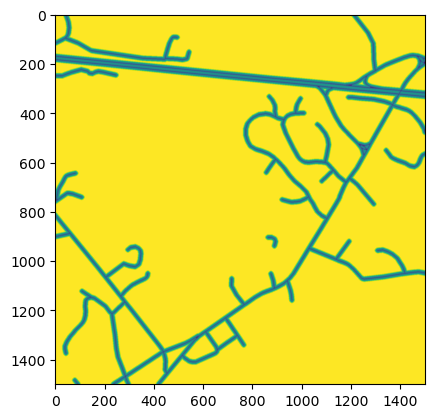

In [10]:
import matplotlib.pyplot as plt
plt.imshow(gt_t[0][0])